# Slaughter Weight vs. Futures Price

In [1]:
import src
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


/Users/ericostring/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
slaughter_live_weight_ge_500 = pd.read_csv('csv/slaughter_live_weight_ge_500.csv')
slaughter_live_weight_ge_500 = src.usda_clean_monthly(slaughter_live_weight_ge_500, historical=True)
slaughter_live_weight_ge_500.head()

Date
1944-01-01    940.0
1944-02-01    946.0
1944-03-01    948.0
1944-04-01    938.0
1944-05-01    921.0
Name: Value, dtype: float64

<AxesSubplot:title={'center':'Live Slaughter Weight (LB)'}, xlabel='Date'>

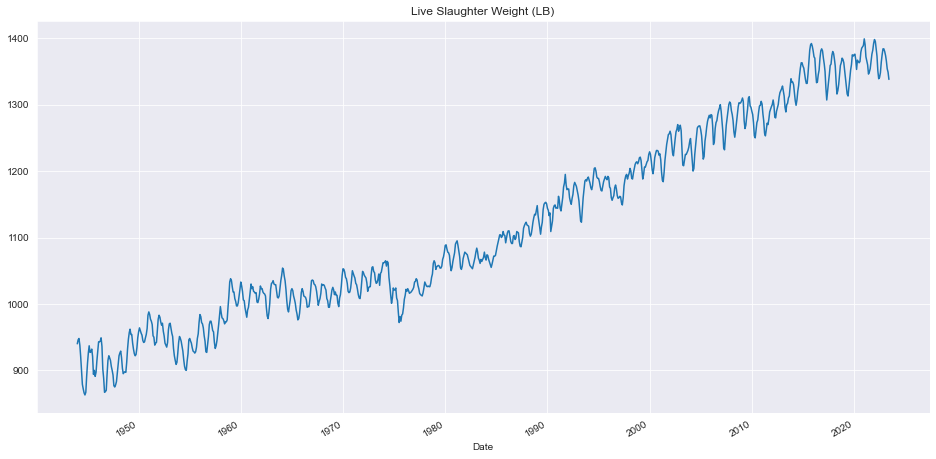

In [3]:
slaughter_live_weight_ge_500.plot(title='Live Slaughter Weight (LB)')

- Clear upward trend, nearly linear. Take percentage yearly difference to make the data more stationary, therefore more comparable across time periods

- Plotting histogram of percentage difference in slaughter weights across months

Text(0.5, 1.0, 'Monthly % change in slaughter weight (1944-2023)')

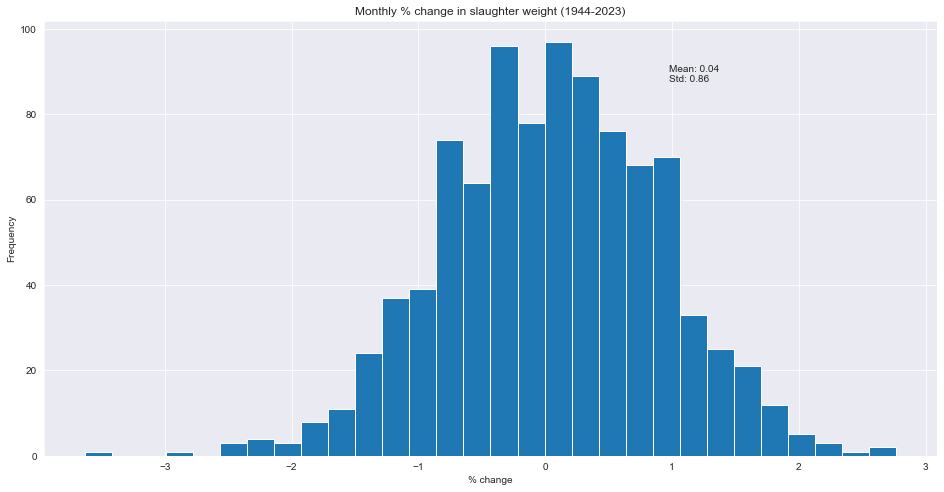

In [4]:
pct_change = slaughter_live_weight_ge_500.pct_change(1)*100

plt.hist(pct_change, bins=30)

mean = pct_change.mean()
std = pct_change.std()

plt.text(0.7, 0.9, f"Mean: {mean:.2f}\nStd: {std:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.ylabel("Frequency")
plt.xlabel("% change")
plt.title("Monthly % change in slaughter weight (1944-2023)")

- There is likely seasonality involved. If we want to know whether a given monthly percentage change in slaughter weight is an outlier, we need to compare against the same month across years

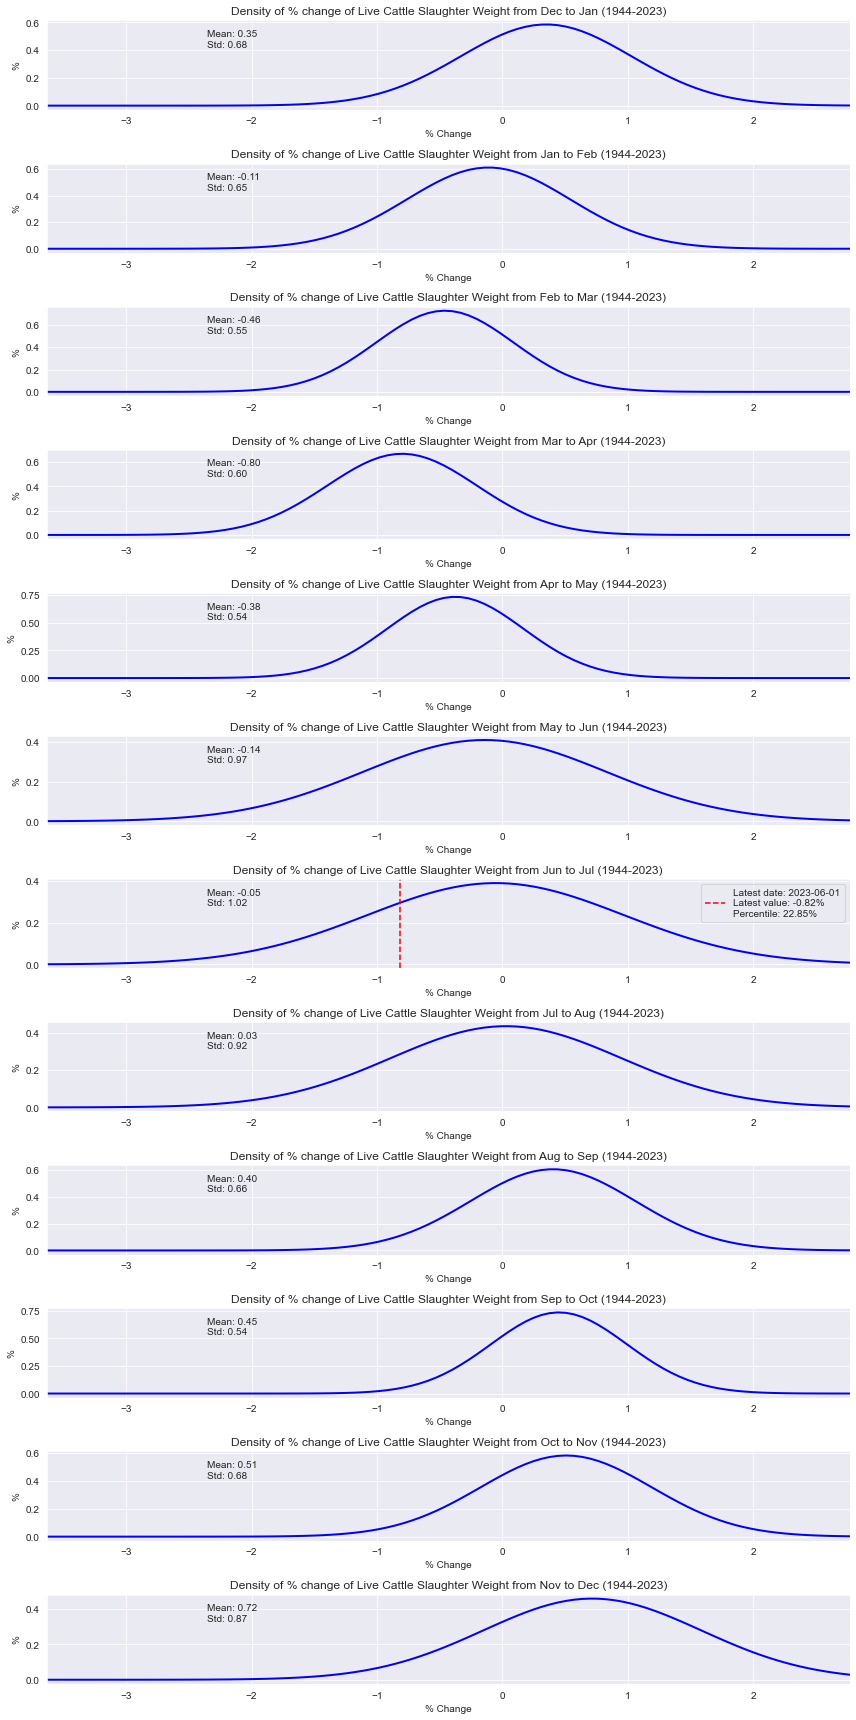

In [5]:
from scipy.stats import norm
import numpy as np

look_back = 1

pct_change_lookback = slaughter_live_weight_ge_500.pct_change(look_back)*100
pct_change_group = pct_change_lookback.groupby(pct_change_lookback.index.month)
x_range = np.linspace(pct_change_lookback.min(), pct_change_lookback.max(), 100)

lates_pct_change = pct_change_lookback[-1]
latest_date = pct_change_lookback.index[-1]


fig, axs = plt.subplots(nrows=12, figsize=(12, 24))


for i, (ax, pct_change_m) in enumerate(zip(axs, pct_change_group)):
    
    pct_change_m = pct_change_m[1].dropna()
    mu, std = norm.fit(pct_change_m)
    pdf_series = norm.pdf(x_range, mu, std)
    ax.plot(x_range, pdf_series, 'b', linewidth=2)

    ax.text(0.2, 0.9, f"Mean: {mu:.2f}\nStd: {std:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.set_title(f'Density of % change of Live Cattle Slaughter Weight from {src.number_to_month[(11+i)%12]} to {src.number_to_month[i]} (1944-2023)')
    ax.set_xlabel('% Change')
    ax.set_ylabel('%')

    ax.set_xlim(pct_change_lookback.min(), pct_change_lookback.max())

    if i == latest_date.month:

        percentile = norm.cdf(lates_pct_change, mu, std)*100
        ax.axvline(x=pct_change_lookback.iloc[-1], color='r', linestyle='--', label=f'Latest date: {latest_date.date()}\nLatest value: {round(lates_pct_change,2)}%\nPercentile: {round(percentile,2)}%')
        ax.legend()

plt.tight_layout()
plt.show()

- Seems to be seasonality in the percentage change in slaughter weight across months
- Spring: the % ∆ of live cattle slaughter weight turns from positive to negative, indicating that cattle are spending less time in the feedlot (assuming weight at entry is constant, and rate of gain is the same)
- Summer: % ∆ remains negative, again indicating cattle are spending a shorter amount of time in the feedlot each month
- Fall: % ∆ flips from negative to positive, therefore cattle are spending longer time in the feedlot each month
- Winter: % ∆ remains positive

- There is a decreasing slaughter weight age during spring and summer, to meet increased summer demand?

- Current data for 2023-06-01 is a mild outlier compared to prior slaughter weights in July

- Next, check out how price % changes in price relate to percentage changes in slaughter weight
- For each month, calculate the Z score of the % change in slaughter weight, with respect to other values for the same month across years

In [6]:
live_cattle_futures = pd.read_csv('csv/live_cattle_futures.csv')
live_cattle_futures = src.clean_tv_data(live_cattle_futures)
adj_live_cattle_futures = src.adjust_series_cpi(live_cattle_futures) # Adjust for inflation

In [7]:
pct_change_slaughter_weight = slaughter_live_weight_ge_500.pct_change()

means = pct_change_slaughter_weight.groupby(pct_change_slaughter_weight.index.month).transform('mean')
stds = pct_change_slaughter_weight.groupby(pct_change_slaughter_weight.index.month).transform('std')

pct_change_z_score = (pct_change_slaughter_weight - means) / stds # Get z-score 

pct_change_z_score_cut = pct_change_z_score[pct_change_z_score.index >= src.Config.analysis_start_date]

In [8]:
pct_change_z_score_cut.tail(10)

Date
2022-09-01    1.181774
2022-10-01    0.651574
2022-11-01    0.212228
2022-12-01   -0.817240
2023-01-01   -0.928855
2023-02-01   -0.493439
2023-03-01   -0.223056
2023-04-01   -0.130563
2023-05-01    0.011346
2023-06-01   -0.689006
Name: Value, dtype: float64

- Since Dec 2022, the % change in slaughter weight between each month has been more negative / smaller, than compares to prior years (besides near 0 %∆ 1st May)
- Even though seasonally the slaughter weight is expected to decrease from February onwards, this years has been an outlier in terms of decreased slaughter weigth, indicating an abnormally high slaughter rate.
- As seen previously, the latest slaughter weigth %∆ is a mild outlier, but so are nearly all the previous 6 months (in the same direction). Taken togeather, this is an outlier.

<AxesSubplot:xlabel='Date'>

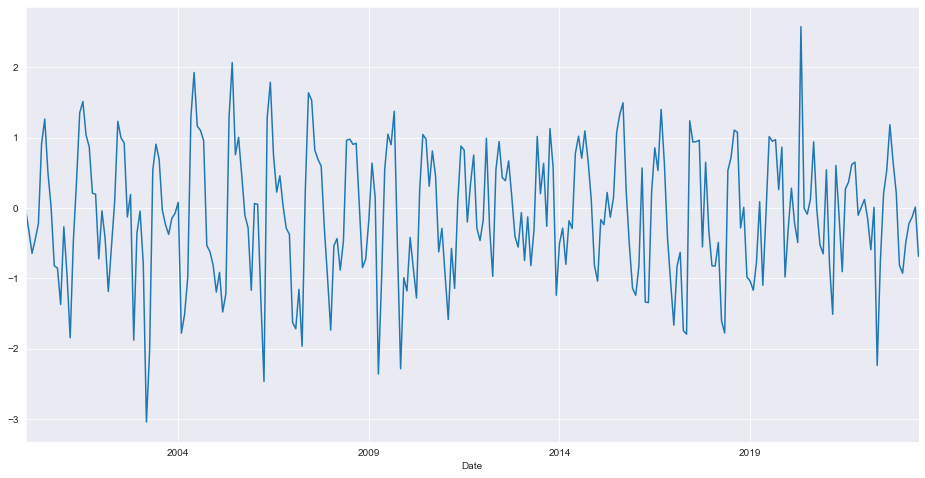

In [9]:
pct_change_z_score_cut.plot()

- Visually looks very close to white noise, but with occasional increase and decrease in standard deviation

- Plotting with % ∆ in Adj. Live Cattle Futures price

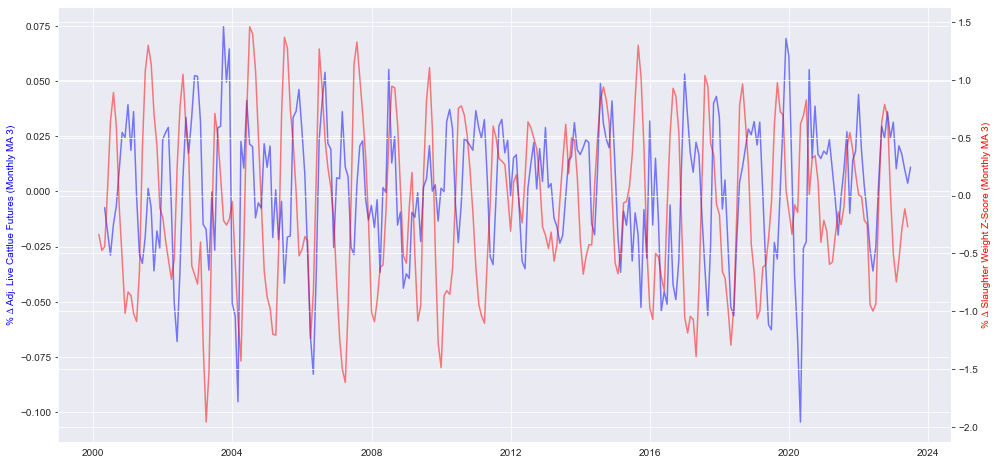

In [10]:
src.lineplot_2_own_axis(
    adj_live_cattle_futures.resample('M').last().rolling(3).mean().pct_change(), 
    pct_change_z_score_cut.rolling(3).mean(),
    '% ∆ Adj. Live Cattlue Futures (Monthly MA 3)',
    '% ∆ Slaughter Weight Z-Score (Monthly MA 3)'
)

- Hard to see any directionaly relationship, but the volatility / standard deviation seems to correlate

- Investigating how price affects slaughter weight
- Hypothesis: If there is an uptick in price between months, we expect feedlots to react by choosing to increase supply for the preceeding months, therefore they will turnover their cattle in the feedlot faster, and slaughter weight should decrease. Therefore, we expect a negative correlation between % price change in a month, with the % change in slaughter weights in the months after.
- Regress % ∆ Adj. Live Cattle Future price with % ∆ Monthly Slaughter Weight Z-score, across different lags

In [18]:
# Below regressions are using data from 2000-2023

src.linear_regression_by_lag(
    adj_live_cattle_futures.resample('MS').last().pct_change(),
    pct_change_z_score
)


Lag 0:		Slope = 1.8569		P-value = 0.0877
Lag 1:		Slope = 0.0809		P-value = 0.9409
Lag 2:		Slope = -1.5652		P-value = 0.1502
Lag 3:		Slope = -3.2174		P-value = 0.0029
Lag 4:		Slope = -2.3483		P-value = 0.0304
Lag 5:		Slope = -3.5381		P-value = 0.0010


- Lag 2-5 have negative coefficients with mostly low P-values, indicating that %∆ in price is negatively associated with %∆ in slaughter weight z-score
- i.e. if we observe an increase in price during the current month, we expect the slaughter wait to decrease during the months after the next one
    - possible explanation is that given the current price rise, producers react by increasing their rate of slaughter in the following months --> causing slaughter weight to decrease
- Lag 0's positive coefficient and fairly low p-value indicates that the %∆ in price correlates positively with %∆ in slaughter weight z-score for the same month
    - possible explanation: say in the current month cattle is slaughtered at a slower pace than usually expected for the month, this leads to heavier cattle (increased %∆ in slaughter weight z-score), and less supply than usual. This is met by an increase in price throughout the same month (as the we are looking at % ∆ in futures clsoing price)

No handles with labels found to put in legend.


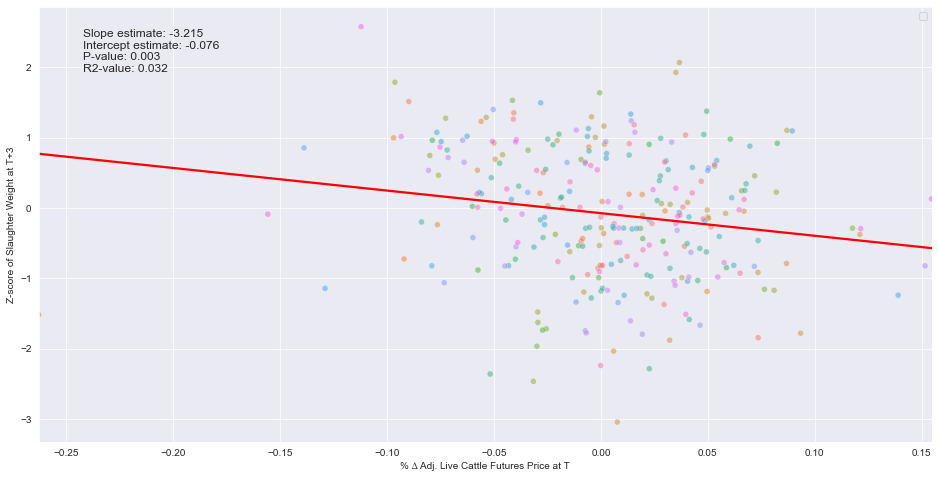

In [12]:
lag = 3

src.scatterplot(
    adj_live_cattle_futures.resample('MS').last().pct_change(),
    pct_change_z_score_cut.shift(-lag),
    '% ∆ Adj. Live Cattle Futures Price at T',
    f'Z-score of Slaughter Weight at T+{lag}',
    reg=True
)

- Next look into how slaughter weight can affect price
- Hypothesis: a higher % ∆ in slaughter weight z-score, means a slower slaughter rate than usual, therefore less supply, in turn a higher % ∆ in price.
- Don't see a reason why prices should have a lag in reaction time
- Therefore, I expect the association to be positive and most significant at early lags, with less positive & significant as time passes

In [13]:
src.linear_regression_by_lag(
    pct_change_z_score,
    live_cattle_futures.resample('MS').last().pct_change()
)

Lag 0:		Slope = 0.0047		P-value = 0.1612
Lag 1:		Slope = 0.0037		P-value = 0.2701
Lag 2:		Slope = 0.0071		P-value = 0.0338
Lag 3:		Slope = 0.0092		P-value = 0.0054
Lag 4:		Slope = 0.0031		P-value = 0.3478
Lag 5:		Slope = -0.0033		P-value = 0.3206


- Lags 0-4 are indeed positive
- Not sure why Lag 3 has the highest coeffiecient, as well as the smallest p-value
- Repeat the above with historical data stretching further back further (1976-2023)

In [14]:
live_cattle_futures_hist = pd.read_csv('csv/live_cattle_futures.csv')
live_cattle_futures_hist = src.clean_tv_data(live_cattle_futures_hist, historical=True)
adj_live_cattle_futures_hist = src.adjust_series_cpi(live_cattle_futures_hist)

In [15]:
min(adj_live_cattle_futures_hist.index)

Timestamp('1976-02-23 00:00:00')

<AxesSubplot:title={'center':'Adj. Live Cattle Futures Price (adj. $/cwt)'}>

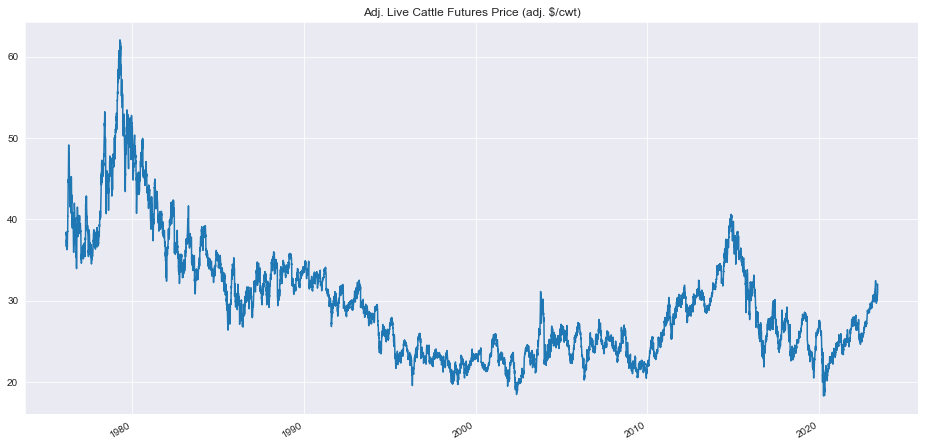

In [16]:
adj_live_cattle_futures_hist.plot(title='Adj. Live Cattle Futures Price (adj. $/cwt)')

In [17]:
src.linear_regression_by_lag(
    pct_change_z_score,
    adj_live_cattle_futures_hist.resample('MS').last().pct_change()
)

Lag 0:		Slope = 0.0047		P-value = 0.0531
Lag 1:		Slope = 0.0035		P-value = 0.1514
Lag 2:		Slope = 0.0013		P-value = 0.5864
Lag 3:		Slope = 0.0050		P-value = 0.0400
Lag 4:		Slope = 0.0016		P-value = 0.5088
Lag 5:		Slope = 0.0039		P-value = 0.1063


- Using data from 1976-2023, the relationship seems similar
- Again, Lag 3 has the highest coefficient with the smallest p-value
    - Not sure why